In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lmfit.models import GaussianModel, LorentzianModel, VoigtModel

,SC110 out [V],Main in [V],SC110 out [V].1,LI out [a.u.]
0,7.6272,-0.082673,7.6272,-3.0
1,7.6278,-0.082916,7.6278,-2.0
2,7.6285,-0.082673,7.6285,2.0
3,7.6291,-0.082673,7.6291,-5.0
4,7.6298,-0.082916,7.6298,-6.0
...,...,...,...,...
995,8.2911,-0.075878,8.2911,22.0
996,8.2918,-0.076364,8.2918,23.0
997,8.2924,-0.076121,8.2924,18.0
998,8.2932,-0.076121,8.2932,19.0


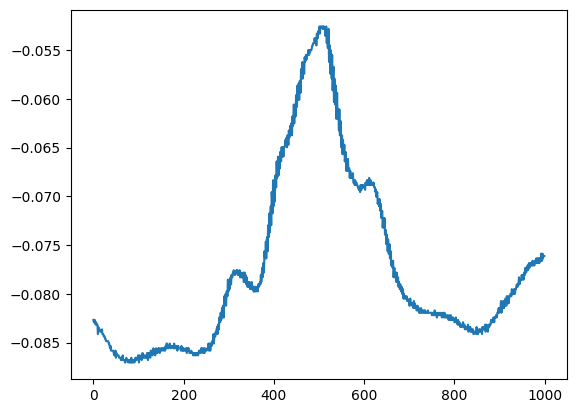

In [131]:
# load data for viz
data = pd.read_csv("SAS_18_03/Pranav/Random/DigiLock-LockData1.txt", sep="\t")
plt.plot(data["Main in [V]"])
data

In [ ]:
# load all data

data = np.zeros((30, 1000))
params = np.zeros((30, 3))
for i in range(30):
    temp = np.loadtxt(
        f"SAS_18_03/Pranav/Random/DigiLock-LockData{i+1}.txt",
        skiprows=1,
        delimiter="\t",
    )
    data[i] = temp[:, 1]

array([[-0.082673, -0.082916, -0.082673, ..., -0.076121, -0.076121,
        -0.076121],
       [-0.082916, -0.083401, -0.082916, ..., -0.076606, -0.076849,
        -0.076849],
       [-0.082673, -0.082916, -0.082188, ..., -0.076121, -0.076121,
        -0.075878],
       ...,
       [-0.081702, -0.08146 , -0.081702, ..., -0.076364, -0.075636,
        -0.075878],
       [-0.081702, -0.081945, -0.081702, ..., -0.077092, -0.077092,
        -0.077092],
       [-0.081945, -0.08146 , -0.08146 , ..., -0.077334, -0.077334,
        -0.077577]], shape=(30, 1000))

[[Model]]
    (((((Model(voigt) + Model(lorentzian, prefix='lz1_')) + Model(lorentzian, prefix='lz2_')) + Model(lorentzian, prefix='lz3_')) + Model(lorentzian, prefix='lz4_')) + Model(lorentzian, prefix='lz5_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 38000
    # data points      = 1000
    # variables        = 18
    chi-square         = 1.11655694
    reduced chi-square = 0.00113702
    Akaike info crit   = -6761.50549
    Bayesian info crit = -6673.16590
    R-squared          = 0.98485811
##  Warning: uncertainties could not be estimated:
    lz1_amplitude:  at initial value
    lz1_amplitude:  at boundary
[[Variables]]
    amplitude:      0.12723376 (init = 1)
    center:         1.06357919 (init = 0)
    sigma:          0.06795177 (init = 1)
    gamma:          0.06795177 == 'sigma'
    fwhm:           0.24471408 == '1.0692*gamma+sqrt(0.8664*gamma**2+5.545083*sigma**2)'
    height:         0.39078991 == '(amplitude/(max(1e-15, sigma*sqrt(2*pi)

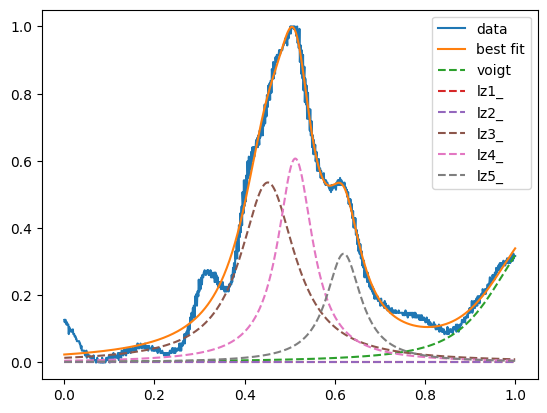

Parameters([('amplitude', <Parameter 'amplitude', value=np.float64(0.12723376286783256), bounds=[-inf:inf]>), ('center', <Parameter 'center', value=np.float64(1.0635791925261566), bounds=[-inf:inf]>), ('sigma', <Parameter 'sigma', value=np.float64(0.06795177266432462), bounds=[0:inf]>), ('gamma', <Parameter 'gamma', value=np.float64(0.06795177266432462), bounds=[-inf:inf], expr='sigma'>), ('fwhm', <Parameter 'fwhm', value=np.float64(0.2447140827443207), bounds=[-inf:inf], expr='1.0692*gamma+sqrt(0.8664*gamma**2+5.545083*sigma**2)'>), ('height', <Parameter 'height', value=np.float64(0.39078990973823396), bounds=[-inf:inf], expr='(amplitude/(max(1e-15, sigma*sqrt(2*pi))))*real(wofz((1j*gamma)/(max(1e-15, sigma*sqrt(2)))))'>), ('lz1_amplitude', <Parameter 'lz1_amplitude', value=np.float64(0.0100000000075555), bounds=[0.01:0.5]>), ('lz1_center', <Parameter 'lz1_center', value=np.float64(0.19984950648877925), bounds=[-inf:inf]>), ('lz1_sigma', <Parameter 'lz1_sigma', value=np.float64(13.904

In [ ]:
# curve fitting lorentzians to a background of voigt profile
ydat = data[0]
ydat -= np.min(ydat)
ydat /= np.max(ydat)  # normalising

xdat = np.linspace(0, 1, 1000)


def add_peak(prefix, center, amplitude=0.005, sigma=0.05):
    peak = LorentzianModel(prefix=prefix)
    pars = peak.make_params()
    pars[prefix + "center"].set(center)
    pars[prefix + "amplitude"].set(amplitude, min=0.01, max=0.5)
    pars[prefix + "sigma"].set(sigma, min=0)
    return peak, pars


model = VoigtModel()
params = model.make_params()
rough_peak_positions = (0.1, 0.2, 0.4, 0.5, 0.61)
for i, cen in enumerate(rough_peak_positions):
    peak, pars = add_peak("lz%d_" % (i + 1), cen)
    model = model + peak
    params.update(pars)
init = model.eval(params, x=xdat)
result = model.fit(ydat, params, x=xdat)
comps = result.eval_components()

print(result.fit_report(min_correl=0.5))

plt.plot(xdat, ydat, label="data")
plt.plot(xdat, result.best_fit, label="best fit")
for name, comp in comps.items():
    plt.plot(xdat, comp, "--", label=name)
plt.legend(loc="upper right")
plt.show()
# you can use the result object to get the parameters of the fit
res = result.params

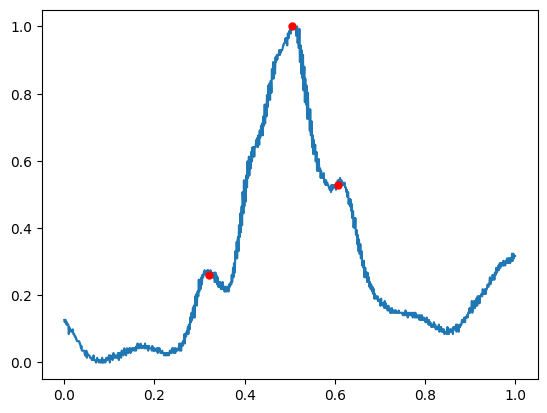

In [149]:
from scipy.signal import find_peaks
from scipy.ndimage import gaussian_filter1d

plt.plot(xdat, ydat)
ydat_smooth = gaussian_filter1d(ydat, 10)
peaks, _ = find_peaks(ydat_smooth, height=0.1)
plt.plot(xdat[peaks], ydat[peaks], "ro", ms=5)
plt.show()

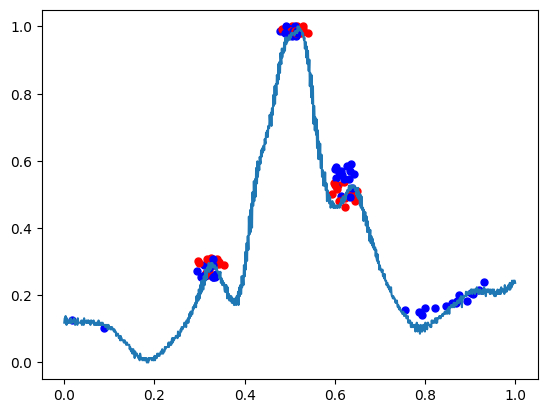

In [ ]:
for i in data:
    ydat = i
    ydat -= np.min(ydat)
    ydat /= np.max(ydat)  # normalising

    ydat_smooth = gaussian_filter1d(ydat, 10)
    peaks, _ = find_peaks(ydat_smooth, height=0.1)
    if len(peaks) < 4:
        plt.plot(xdat[peaks], ydat[peaks], "ro", ms=5)

    if len(peaks) > 3:
        plt.plot(
            xdat[peaks], ydat[peaks], "bo", ms=5
        )  # locations of the clusters of the peaks

plt.plot(xdat, ydat)
# here, for CNN annotation we would require additional data such as linewidths, amplitudes, etc.